# **Distance Predictor Part 5**
Author: Declan Costello

Date: 8/19/2023

## **Part 5 Description**

Here I create and evaluate the final model

## **Table of Context**

1. [Installation](#Installation)
2. Data Import
3. Preprocessing
4. Piplelines
5. Train Test Split
6. Stratify
7. Voting Regressor
8. Results
9. Feature Importantance
10. Feature Imoprtance According to Model
11. Saving Model

**Installation**
- The following installs the necessary packages

In [1]:
import bz2
import lime
import joblib
import fastbook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict,cross_val_score

In [2]:
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.plotting import figure
from bokeh.layouts import row
output_notebook()

Loading BokehJS ...

**[Controlling Randomness](https://scikit-learn.org/stable/common_pitfalls.html#controlling-randomness)**

In [3]:
random_state = np.random.RandomState(seed=42)

**Data Import**

In [4]:
data = pd.read_csv('FE_data.csv')

**Preprocessing**

In [5]:
numeric_features = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
numeric_transformer = Pipeline(steps=[
    ("scaler", RobustScaler())
])


categorical_features = ["home_team","stand","p_throws",'grouped_pitch_type','fav_platoon_split_for_batter']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")


preprocessor = ColumnTransformer(transformers=[
    ("num_transform", numeric_transformer, numeric_features),
    ("cat_transform", categorical_transformer, categorical_features)
])

**Pipelines**

In [6]:
XGBRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("Random Forest Regressor", XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10))])

RandomForestRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("rf", RandomForestRegressor())])

MLPRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("MLPR", MLPRegressor())])

GradientBoostingRegressor_pipeline = Pipeline(steps=[(
    "preprocesser", preprocessor), 
    ("gbr", GradientBoostingRegressor())])

**Train Test Split**

In [7]:
feature_cols = ['launch_angle','launch_speed','pfx_x','pfx_z',"release_speed","home_team","stand","p_throws","fav_platoon_split_for_batter","grouped_pitch_type", "domed", "spray_angle",'is_barrel','Pop','pull_percent']
X = data.loc[:, feature_cols]

target_cols = ['hit_distance_sc']
y = data.loc[:, target_cols]

**[Stratify](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**
- [I can only stratify three features because only working with ~100k rows](https://github.com/davidsbatista/text-classification/issues/1)
- [Eventual StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05,random_state=random_state.randint(1, 101),stratify = X[['home_team',"stand",'grouped_pitch_type']])

**VotingRegressor**
- Finally, we will visualize the predictions. The red stars show the average prediction made by VotingRegressor.

In [9]:
er = VotingRegressor([('ogxg', XGBRegressor_pipeline), ('MLPR', MLPRegressor_pipeline),('gbr',GradientBoostingRegressor_pipeline),('rf', RandomForestRegressor_pipeline)])
er.fit(X_train, y_train.values.ravel())

preds = er.predict(X_valid)

predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

[14:12:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


**DummyRegressor**

- DummyRegressor Comparison for Baseline Berformance

In [10]:
dt = DummyRegressor().fit(X_train, y_train.values.ravel())
print(f'Dummy score is {dt.score(X_valid, y_valid.values.ravel())}')

print(f'VotingRegressor score is {er.score(X_valid, y_valid.values.ravel())}')

Dummy score is -0.0001201286353900155
VotingRegressor score is 0.9902492558364727


## **Results**

**Residuals**

In [11]:
predicted_distance = list(preds)
actual_distance = y_valid['hit_distance_sc'].to_list()

final_pipe_results = pd.DataFrame()

final_pipe_results['predicted_distance'] = predicted_distance

final_pipe_results['actual_distance'] = actual_distance

final_pipe_results['residual'] = final_pipe_results['actual_distance'] - final_pipe_results['predicted_distance']

p = figure(height=500, width=500,title="Predicted vs Actual Distance")
p.circle(actual_distance, predicted_distance, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
p.xaxis.axis_label = 'Actual Distance'
p.yaxis.axis_label = 'Predicted distance'

z = figure(height=500, width=500,title="Residual vs Predicted Distance")
z.circle(final_pipe_results.predicted_distance, final_pipe_results.residual, size=5, line_color="skyblue", fill_color="skyblue", fill_alpha=0.3)
z.xaxis.axis_label = 'Predicted Distance'
z.yaxis.axis_label = 'Residual (actual - predicted)'

b = figure(width=1000, height=500, toolbar_location=None,
           title="Normality of Residuals")

# Histogram
bins = np.linspace(-50, 50, 100)
hist, edges = np.histogram(final_pipe_results.residual, density=True, bins=bins)
b.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white")

b.y_range.start = 0
b.x_range.start = -20
b.x_range.end = 20

b.xaxis.axis_label = "Residuals"
b.yaxis.axis_label = "Distribution Count"

grid = gridplot([[row(p, z)], 
                 [b]])
show(grid)

**Confusion Matrix**

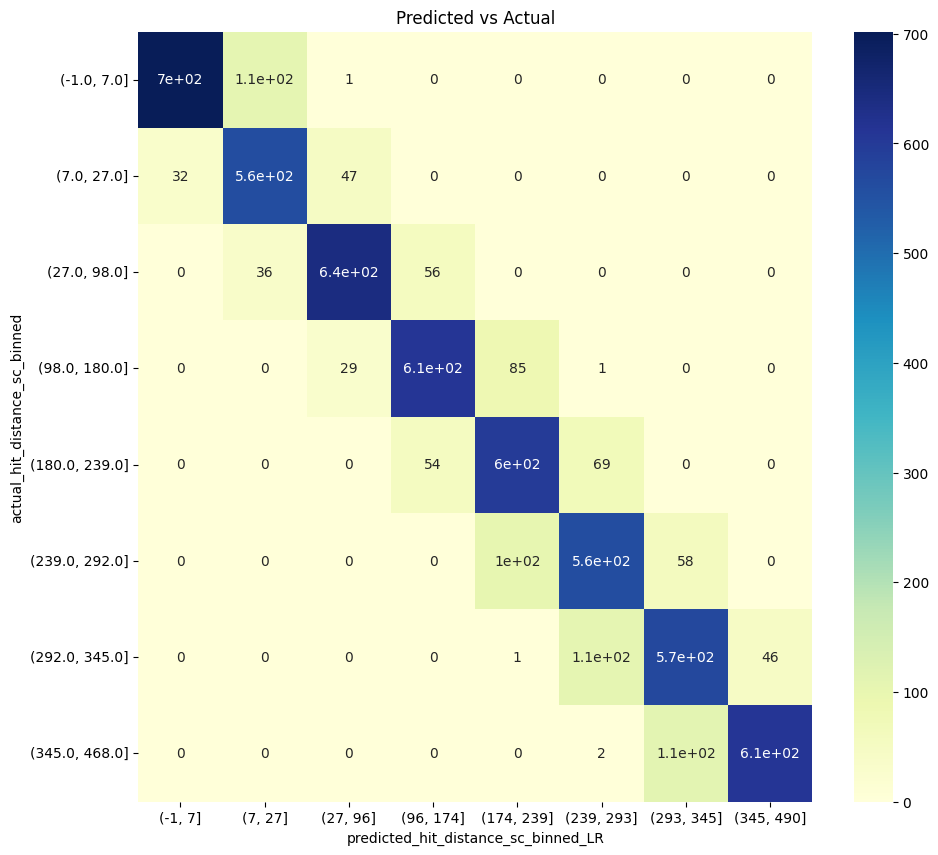

In [12]:
y_valid['actual_hit_distance_sc_binned'] = pd.qcut(y_valid['hit_distance_sc'], q=8, precision=0)
y_valid = y_valid.reset_index()
y_valid = y_valid.reset_index()
y_valid = y_valid.rename(columns={'level_0': 'key'})


df_predicted_LR = pd.DataFrame(predicted_distance, columns=['predicted_hit_distance_sc'])
bins = [-1, 7, 27, 96, 174, 239, 293, 345, 490]
df_predicted_LR['predicted_hit_distance_sc_binned_LR'] = pd.cut(df_predicted_LR['predicted_hit_distance_sc'], bins)
df_predicted__LR = df_predicted_LR.reset_index()
df_predicted__LR = df_predicted__LR.rename(columns={'index': 'key'})
result_2 = pd.merge(y_valid, df_predicted__LR, on="key")
result_2_heatmap = result_2.pivot_table(index='actual_hit_distance_sc_binned', columns='predicted_hit_distance_sc_binned_LR', aggfunc='count')


plt.figure(figsize=(50,10))
plt.subplot(141)
sns.heatmap(result_2_heatmap['hit_distance_sc'],cmap="YlGnBu",annot=True)
plt.title('Predicted vs Actual')
plt.show()


## **Feature Importance**

**[Permutaion Importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)**

- [scikit-learn example](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py)

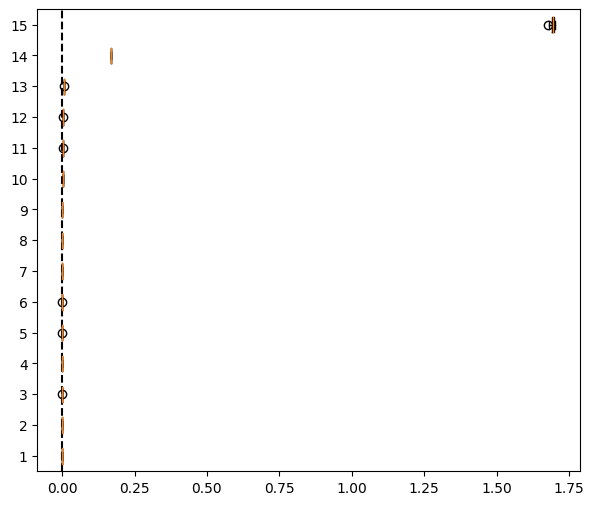

In [13]:
result = permutation_importance(er, 
                                X_train, 
                                y_train.values.ravel(), 
                                n_repeats=10,
                                random_state=random_state.randint(1, 101))

fig, ax = plt.subplots(figsize=(7, 6))

perm_sorted_idx = result.importances_mean.argsort()

ax.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False
)
ax.axvline(x=0, color="k", linestyle="--")

**Redundant Features**
- Not importnat until at least 100 features, but good to have

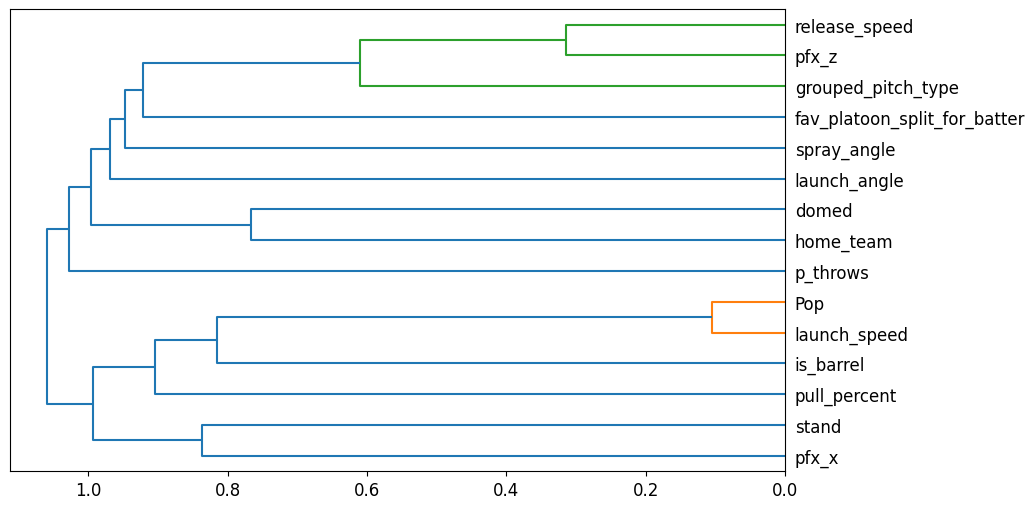

In [11]:
fastbook.cluster_columns(X_train)

**Partial Dependence Plot**

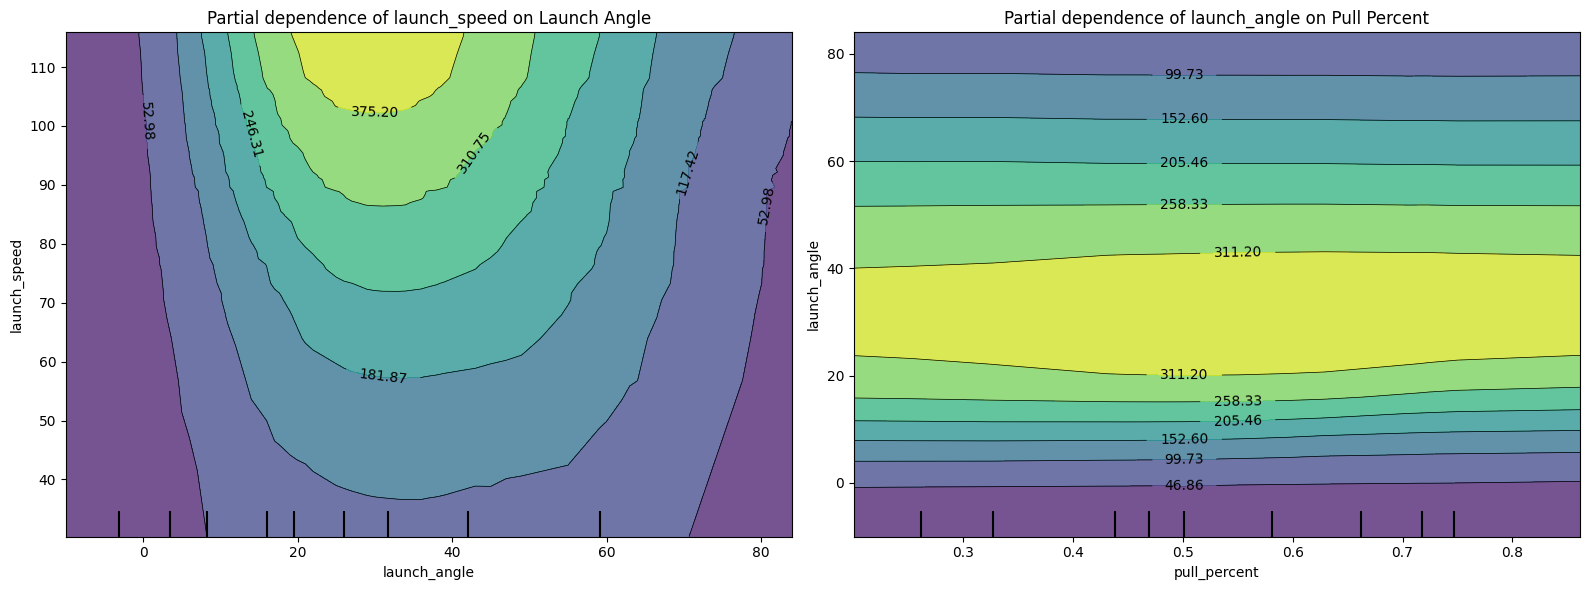

In [14]:
# Filter the data
X_train_filtered = X_train[X_train['launch_angle'].between(-10, 100)]

# Create two partial dependence plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1
f_names = [('launch_angle', 'launch_speed')]
disp1 = PartialDependenceDisplay.from_estimator(er, X_train_filtered[:random_state.randint(50, 101)], f_names, ax=axs[0])
axs[0].set_xlim(-10, 100)
axs[0].set_title('Partial dependence of launch_speed on Launch Angle')

# Plot 2
f_names = [('pull_percent', 'launch_angle')]
disp2 = PartialDependenceDisplay.from_estimator(er, X_train_filtered[:random_state.randint(10, 51)], f_names, ax=axs[1])
axs[1].set_xlim(-10, 100)
axs[1].set_title('Partial dependence of launch_angle on Pull Percent')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## **Feature Importance According to Model**

**Lime**

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,  train_size=0.95, test_size=0.05, random_state=random_state.randint(1, 101),stratify = X[['home_team',"stand",'grouped_pitch_type']])
#hopefully strat works here?

# Define transformers for categorical and numerical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_features]

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

numeric_transformer = Pipeline([
    ('scaler', RobustScaler()),
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_cols)
    ])

# Fit and transform the preprocessing pipeline on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Define a linear regression model
XGBRegressor = XGBRegressor(XGB__learning_rate=0.1, max_depth=5, min_child_weight = 1, subsample = 1.0, n_estimators=10)

RandomForestRegressor = RandomForestRegressor()

MLPRegressor = MLPRegressor()

GradientBoostingRegressor = GradientBoostingRegressor()

lime_er = VotingRegressor([('r1', XGBRegressor), ('r2', RandomForestRegressor),('r3',MLPRegressor),('r4',GradientBoostingRegressor)])
lime_er.fit(X_train_processed, y_train)

# Create a LIME explainer in regression mode
explainer = LimeTabularExplainer(X_train_processed, mode="regression")

# Define a custom predictor function for LIME
def custom_predictor(X):
    #return regressor.predict(X)
    return lime_er.predict(X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14:53:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "XGB__learning_rate" } are not used.



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
def final_lime(instance_idx_val):
    #also print which model was chosen?

    print(X_valid.iloc[instance_idx_val])

    explanation = explainer.explain_instance(X_valid_processed[instance_idx_val], custom_predictor)

    explanation.show_in_notebook()

final_lime(np.random.randint(1, 101))

launch_angle                        28.0
launch_speed                        94.6
pfx_x                              -1.22
pfx_z                               1.18
release_speed                       92.8
home_team                             SD
stand                                  L
p_throws                               R
fav_platoon_split_for_batter         Yes
grouped_pitch_type              fastball
domed                                  0
spray_angle                     17.87632
is_barrel                              0
Pop                                  1.8
pull_percent                     0.63309
Name: 106620, dtype: object


**StratifiedKFold**
- How does the VotingRegressor react to new data?

In [27]:
# Define feature and target columns
feature_cols = ['launch_angle', 'launch_speed', 'pfx_x', 'pfx_z', "release_speed", "home_team", "stand", "p_throws",
                "fav_platoon_split_for_batter", "grouped_pitch_type", "domed", "spray_angle", 'is_barrel', 'Pop',
                'pull_percent']
target_cols = ['hit_distance_sc']

# Split data into training and validation sets with stratified sampling
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.95, test_size=0.05, random_state=np.random.randint(1, 101),
                                                      stratify=X[['home_team', "stand", 'grouped_pitch_type']])

# Define transformers for categorical and numerical columns
numeric_cols = [col for col in feature_cols if col not in categorical_features]

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

numeric_transformer = Pipeline([
    ('scaler', RobustScaler()),
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_cols)
    ])

# Fit and transform the preprocessing pipeline on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_valid_processed = preprocessor.transform(X_valid)

# Define individual regression models
xgb_regressor = XGBRegressor(learning_rate=0.1, max_depth=5, min_child_weight=1, subsample=1.0, n_estimators=10)
rf_regressor = RandomForestRegressor()
mlp_regressor = MLPRegressor()
gb_regressor = GradientBoostingRegressor()

# Create a VotingRegressor
strat_er = VotingRegressor(estimators=[
    ('xgb', xgb_regressor),
    ('rf', rf_regressor),
    ('mlp', mlp_regressor),
    ('gb', gb_regressor)
])

# Define the StratifiedKFold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=np.random.randint(1, 101))

# Perform cross-validation and get cross-validated predictions
#cv_predictions = cross_val_predict(strat_er, X_train_processed, y_train, cv=kf)
#for each predction set I cloud look at shap, permutations, limes, andect again, but in reality they are all within 0.001 MAE, small variation gives me confidence in the VotingRegressot

# Now you can evaluate the performance of the VotingRegressor using cv_predictions
print(cross_val_score(strat_er, X_train_processed, y_train, cv=kf))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_voting.py:604: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Sto

[0.96917526 0.96817212 0.96858302 0.96853006 0.96929262]


**Saving Model**

In [ ]:
# Compress the model using bz2 and save it with joblib
with bz2.BZ2File('compressed_9_model.joblib.bz2', 'wb', compresslevel=9) as f:
    joblib.dump(er, f)